In [2]:
# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
import datetime as dt
from sklearn import preprocessing
pd.set_option('display.max_columns', None)



# stats tests 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn import datasets


In [55]:
#read the data
data = pd.read_csv("KaggleV2-May-2016.csv", parse_dates=["AppointmentDay", "ScheduledDay"])
#data=dataframe.copy()

In [56]:
# This turns the No-show variable into a binary of 1 and 0, 1 means a no-show.  
data['Alvo'] = data['No-show'].apply(lambda x: 1 if x == 'Yes' else 0)

Handicap and Gender

In [57]:
data['Handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [58]:
# binarizing handicap and Gender
data['handicap']= data['Handcap'].apply(lambda x: 0 if x==0 else 1)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)


Date tratament

In [63]:
# Create a column that is the day of the week of the appointment 
data["week_day"] = data["AppointmentDay"].dt.weekday_name
# create a column for the time between when a patient scheduled the appointment to the appointment.
data["wait"] = (data["AppointmentDay"].dt.date - data["ScheduledDay"].dt.date).dt.days
#print("Dias consultas", data["week_day"].value_counts())
#print("Tempo de espera negativo:", data[data["wait"]<0].count())
# drop negative wait time rows and the Saturday appointments as they are clearly outliers. 
data= data[data["week_day"] != "Saturday"]
data = data[data['wait'] > 0]
#drop out  too all patients with wait = 0. The DSS is not useful for them.


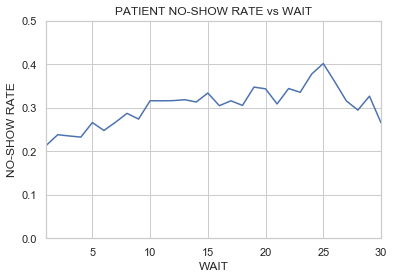

In [7]:
# create a plot of no-show rate compared to the appointment's wait, discovering breaks to better discretize data. Since
#we  don't  have a better semantical choice
data.groupby('wait').mean().Alvo[:30].plot()
plt.title("PATIENT NO-SHOW RATE vs WAIT")
plt.ylabel("NO-SHOW RATE")
plt.xlabel("WAIT")
plt.ylim(0,.50)
plt.show()

In [8]:
#we observed a big increase up to two days, then the non-attendance rate increases again in 5 days until the tenth day. After that, you have
#a smooth change and maintain same average until the 21. Have another interval in 25 days.

def bin_wait_time(df):
                        # bin ranges 0, 1, 2-4, 5-10, 10-21, 25 < 
    col="wait"
    if df[col]   <1:
        return 0
    elif df[col] <2:
        return 1
    elif df[col] <5:
        return 3
    elif df[col] <10:
        return 7
    elif df[col] < 21:
        return 16
    elif df[col] < 25:
        return 20
    else: 
        return 25

In [9]:
#create wait_binned
data["wait_binned"]= data.apply(bin_wait_time, axis=1)

Age Analysis

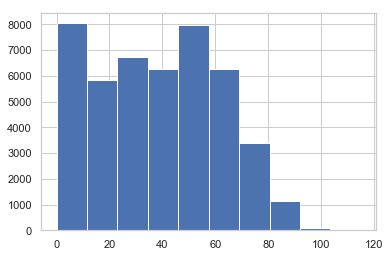

In [10]:
data.drop_duplicates('PatientId')['Age'].hist()

In [11]:
# filter out negative age
data = data[data.Age >=0]

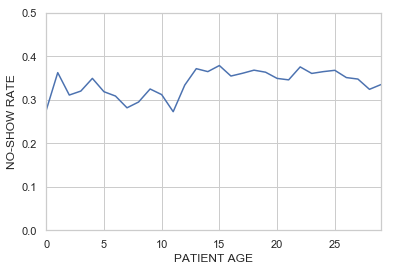

In [12]:
# create a plot of no-show rate compared to the patients age, discovering breaks to discretize data
data.groupby('Age').mean().Alvo[:30].plot()
plt.ylabel("NO-SHOW RATE")
plt.xlabel("PATIENT AGE")
plt.ylim(0,.5)
plt.show()
#data.groupby('appointment_day')[["no_show_bi"]].mean()

In [13]:
#Discretize data in changes directions of graph. It is easiest to realize it in table. Not showed here. 
def bin_age(df):
    '''Creates a function to turn age into 6 groups of binned ages.'''
                        # bin ranges 0-3, 4-7, 8-27, 28-40, 41-60, 61 < 
    if df["Age"] <1:
        return '1'
    elif df["Age"] <5:
        return '5'
    elif df["Age"] <15:
        return '15'
    else:
        return '15ormore'

In [14]:
# apply binning function
data["age_binned"]= data.apply(bin_age, axis=1)

Zones and Neighbourhood analysis

In [15]:
# adding another column with zones neighbourhoods
dataframeZone={}
dataframeZone=pd.read_csv( "regiao_adm.csv", delimiter="," )
dataframeZone["Neighbourhood"]=dataframeZone["Neighbourhood"].apply(lambda x: x.upper().strip())
data['Neighbourhood']=data['Neighbourhood'].apply(lambda x: x.upper().strip())
data=pd.merge(data, dataframeZone, on='Neighbourhood', how='left')


In [16]:
# Order the zones by the mean income - data of 2010 (http://legado.vitoria.es.gov.br/regionais/dados_regiao/regiao_9/regiao9d.asp)
def order_zone(df):
    col='Adm_Zone'
    if df[col] =="VII – São Pedro":
        return 1
    elif df[col] == "II - Santo Antônio":
        return 2
    elif df[col] == "IV – Maruípe":
        return 3
    elif df[col] =="VI – Continente":
        return 4
    elif df[col] =="III - Bento Ferreira/Jucutuquara":
        return 5
    elif df[col] =="I – Centro":
        return 6
    else:
        return 7


In [17]:
data["order_zone"]= data.apply(order_zone, axis=1)

In [18]:
#frequency
data.drop_duplicates('PatientId')['order_zone'].value_counts()

4    10314
3     9031
1     6743
2     6536
5     5398
7     3993
6     3825
Name: order_zone, dtype: int64

In [19]:
#x= data[data['PatientId']=='7414864771918']

Behavior Patient - Temporal Features

In [20]:
#previous number of no-shows
def behavior_noshow(row):
        appointment_passed = data.loc[(data.PatientId == row.PatientId) & (data.Alvo==0)& (data.AppointmentDay < row.AppointmentDay), 'Alvo']
        noshow_passed = data.loc[(data.PatientId == row.PatientId) & (data.AppointmentDay < row.AppointmentDay), 'Alvo']

        #print(consultas_passado)
        row["n_appoint_passed"] = len(appointment_passed)
        row["n_noshow_passed"] = noshow_passed.sum()
        return row

In [21]:
data=data.apply(behavior_noshow, axis=1)

In [22]:
#embbeded more informations about time. State last patient's appointments. For those who are on your first appoitment was created dummy feature.
data = data.sort_values(by = ['AppointmentDay', 'ScheduledDay'], axis = 0)
data['stat_last_app'] = data.groupby('PatientId')['Alvo'].apply(lambda x : x.shift(1))
#keep the original feature, with no-show and first_appointment mixed, to make tests 
data['stat_last_app_ori'] = data['stat_last_app'].fillna(0)
# create new dummy that indicate if is the first pacient's appointment, and kepp only the dummy that show if patient failed your last appointment
data['stat_last_app'].fillna("First", inplace=True)
data=pd.get_dummies(data=data, columns=['stat_last_app'])
data.drop(['stat_last_app_0.0','stat_last_app_1.0'],inplace=True, axis=1)



In [ ]:
#data.to_csv("temp.csv", sep=",") 

In [79]:
data = pd.read_csv("temp.csv", parse_dates=["AppointmentDay", "ScheduledDay"])


/Users/rogerio/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [80]:
data["n_appoint_passed"].value_counts()

0     52380
1     11756
2      4050
3      1587
4       776
5       451
6       316
7       199
8       133
9       107
10       59
11       48
12       32
13       20
14       16
15        9
16        7
17        4
18        3
20        3
21        1
19        1
22        1
Name: n_appoint_passed, dtype: int64

In [81]:
def bin_no_appointment_passed(df):
    col="n_appoint_passed"
    if df[col]  <1:
        return "0"
    elif df[col] <2:
        return "1"
    elif df[col] <3:
        return "2"
    else: 
        return "3ormore"

In [82]:
data["n_appoint_passed_bin"]= data.apply(bin_no_appointment_passed, axis=1)

In [83]:
data['n_appoint_passed_bin'].value_counts()

0          52380
1          11756
2           4050
3ormore     3773
Name: n_appoint_passed_bin, dtype: int64

In [84]:
# How many people has 0 no-show and are in your first appointment? The no-show increase only finished next appointment
#print('frequency number no-show\n'
#      ,data['n_noshow_passed'].value_counts())
print(((data['n_noshow_passed']==0) & (data['stat_last_app_First']==1)).sum(),'out of',(data['n_noshow_passed'] ==0).sum(),'patients who never failed, are on your first appointment')

45840 out of 62777 patients who never failed, are on your first appointment


In [85]:
data['n_noshow_passed'].value_counts()

0     62777
1      7046
2      1469
3       415
4       160
5        54
6        19
7         8
8         7
10        2
9         2
Name: n_noshow_passed, dtype: int64

In [86]:
#in this case, i will keep two different collunmns to not mixed the patients with no historic no-shows and there are on your first appointment. 
#split who never failed, have one fail and 2 or more (decison made by frequency)
def bin_no_show_passed(df):
    col="n_noshow_passed"
    if df[col] < 1:
        return "0"
    elif df[col] <2:
        return "1"
    else: 
        return "2ormore"

In [87]:
data["n_noshow_passed_bin"]= data.apply(bin_no_show_passed, axis=1)

In [88]:
data["n_noshow_passed_bin"].value_counts()

0          62777
1           7046
2ormore     2136
Name: n_noshow_passed_bin, dtype: int64

In [89]:
# garante a transformação da data pra categorica de quem leu o csv temp.
data["week_day"] = data["AppointmentDay"].dt.weekday_name


In [90]:
#todas variaveis disponiveis
data.columns



Index(['Unnamed: 0', 'PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'Alvo',
       'handicap', 'week_day', 'wait', 'wait_binned', 'age_binned', 'Adm_Zone',
       'order_zone', 'n_appoint_passed', 'n_noshow_passed',
       'stat_last_app_ori', 'stat_last_app_First', 'n_appoint_passed_bin',
       'n_noshow_passed_bin'],
      dtype='object')

In [91]:
#category features
conjunto1_categ =['age_binned', "Adm_Zone", "week_day"]
conjunto2_categ=['Adm_Zone','week_day']
conjunto3_categ=['age_binned', "Adm_Zone", "week_day", 'n_noshow_passed_bin', 'n_appoint_passed_bin']
#numeric features 
conjunto1_numerical=['wait','n_noshow_passed', "n_appoint_passed"]
conjunto2_numerical=['wait','n_noshow_passed', "n_appoint_passed", "Age"]
conjunto3_numerical=['wait']

#binary features - commom in all sets
binary=["Gender","Scholarship", "Hipertension","Diabetes","Alcoholism","handicap","SMS_received", 'stat_last_app_First','stat_last_app_ori',"Alvo"]

#to split train-test
date_to_split = ["AppointmentDay"]

#Conjunto 1
conjunto1 = data[conjunto1_categ + conjunto1_numerical + binary + date_to_split]
conjunto1 = pd.get_dummies(conjunto1, columns=(conjunto1_categ), drop_first=True)
##escaling to conjunto 1
n_test = conjunto1[conjunto1_numerical]
x = n_test.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
n_test = pd.DataFrame(x_scaled, columns=conjunto1_numerical)
l_test = conjunto1.drop(conjunto1_numerical, axis=1)
conjunto1 = pd.concat([n_test, l_test], axis=1)


#Conjunto 2
conjunto2 = data[conjunto2_categ + conjunto2_numerical +binary + date_to_split]

#Conjunto 3
conjunto3 = data[conjunto3_categ + conjunto3_numerical + binary + date_to_split]


/Users/rogerio/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


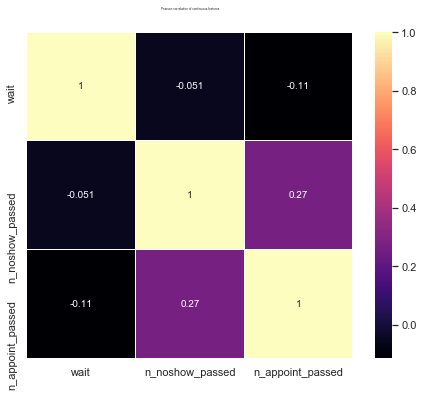

In [92]:
#correlatrion numeric fefatures
colormap = plt.cm.magma
plt.figure(figsize=(8,6))
plt.title('Pearson correlation of continuous features', y=1.05, size=3)
sns.heatmap(data[conjunto1_numerical].corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

In [93]:
conjunto1_train = conjunto1[(conjunto1.AppointmentDay< '2016-05-29')& (conjunto1.AppointmentDay>='2016-04-29')]
conjunto1_test = conjunto1[conjunto1.AppointmentDay >  '2016-05-29']

In [94]:
conjunto2_train = conjunto2[(conjunto2.AppointmentDay< '2016-05-29')& (conjunto2.AppointmentDay>='2016-04-29')]
conjunto2_test = conjunto2[conjunto2.AppointmentDay >  '2016-05-29']

In [95]:
conjunto3_train = conjunto3[(conjunto3.AppointmentDay< '2016-05-29')& (conjunto3.AppointmentDay>='2016-04-29')]
conjunto3_test = conjunto3[conjunto3.AppointmentDay >  '2016-05-29']

In [96]:
conjunto1_train.drop('AppointmentDay', inplace=True, axis=1)
conjunto1_test.drop('AppointmentDay', inplace=True, axis=1)

/Users/rogerio/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
conjunto2_train.drop('AppointmentDay', inplace=True, axis=1)
conjunto2_test.drop('AppointmentDay', inplace=True, axis=1)

In [22]:
conjunto3_train.drop('AppointmentDay', inplace=True, axis=1)
conjunto3_test.drop('AppointmentDay', inplace=True, axis=1)

In [23]:
print("Alvo Train:", (conjunto1_train['Alvo']==1).sum()/(conjunto1_train['Alvo'].count()))
print("Alvo Test:",(conjunto1_test['Alvo']==1).sum()/(conjunto1_test['Alvo'].count()))


Alvo Train: 0.2960530354183291
Alvo Test: 0.2621935372086979


In [24]:
print("Alvo Train:", (conjunto2_train['Alvo']==1).sum()/(conjunto2_train['Alvo'].count()))
print("Alvo Test:",(conjunto2_test['Alvo']==1).sum()/(conjunto2_test['Alvo'].count()))


Alvo Train: 0.2960530354183291
Alvo Test: 0.2621935372086979


In [25]:
print("Alvo Train:", (conjunto3_train['Alvo']==1).sum()/(conjunto3_train['Alvo'].count()))
print("Alvo Test:",(conjunto3_test['Alvo']==1).sum()/(conjunto3_test['Alvo'].count()))

Alvo Train: 0.2960530354183291
Alvo Test: 0.2621935372086979


In [26]:
#conjunto1 - Variaveis numericas (wait, n_noshow_passed e n_appoin_passed) normalizadas - Regressao 
conjunto1_train.to_csv('RL_train.csv', sep=',')
conjunto1_test.to_csv('RL_test.csv', sep=',')

In [27]:
#conjunto2 Decision Tree and Rules Induction
conjunto2_train.to_csv('DT_RI_train1.csv', sep=',')
conjunto2_test.to_csv('DT_RI_test1.csv', sep=',')

In [28]:
##conjunto3 - Numeric features (n_noshow_passed e n_appoin_passed) discretized by frequency
conjunto3_train.to_csv('DT_RI_train2.csv', sep=',')
conjunto3_test.to_csv('DT_RI_test2.csv', sep=',')

In [29]:
conjunto3_train.head(2)

,age_binned,Adm_Zone,week_day,n_noshow_passed_bin,n_appoint_passed_bin,wait,Gender,Scholarship,Hipertension,Diabetes,Alcoholism,handicap,SMS_received,stat_last_app_First,stat_last_app_ori,Alvo
0,15ormore,VII – São Pedro,4,0,0,115,1,0,1,1,0,1,1,1,0.0,0
1,15ormore,VII – São Pedro,4,0,0,115,0,0,1,0,0,0,1,1,0.0,0
